In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score  
from scipy.stats import norm
import statsmodels.api as sm
from scipy.special import expit as sigmoid

from experiments.selector import Selector
from flows.train import train_with_validation
from utils.utils import ci_bisection

In [180]:
data_path = "experiments/single_cell/"
df = pd.read_csv(os.path.join(data_path, "filtered_gene_expression.csv"), index_col=0)
cell_types = pd.read_csv(os.path.join(data_path, "cell_types.csv"), index_col=0)
cell_types = cell_types.loc[df.index]
df['type'] = cell_types['fine_cell_type']
df = df.loc[df['type'].isin(['memory B cell', 'naive B cell'])]

X = np.array(df.iloc[:, :-1])
y = np.array(df['type'] == 'memory B cell')
print(X.shape, round(y.mean(), 2))

(233, 2000) 0.6


In [181]:
X_PC = np.linalg.svd(X, full_matrices=False)[0][:, :10] * np.sqrt(len(y))
df_pc = pd.DataFrame(X_PC, columns=['PC' + str(i) for i in range(1, 11)])
df_pc['y'] = list(df['type'])

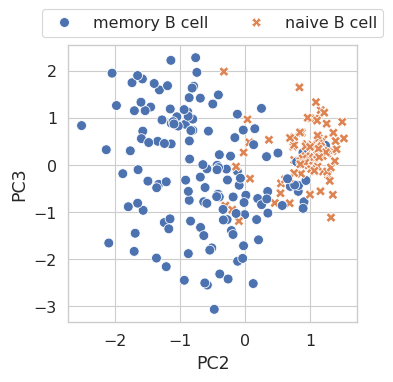

In [182]:
plt.figure(figsize=(4, 4))
sns.set_theme(context='paper', style='whitegrid', font_scale=1.3)
sns.scatterplot(data=df_pc, x='PC2', y='PC3', hue='y', style='y', s=50)
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2)
plt.tight_layout()

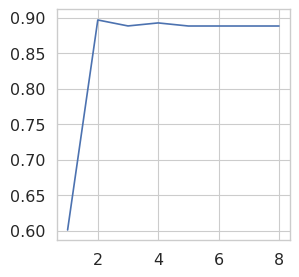

In [183]:
grid = np.arange(1, 9)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
cv_accuracy = []
for k in grid:
    clf = LogisticRegression(fit_intercept=False, C=10.)
    acc = cross_val_score(clf, X_PC[:, :k], y, cv=cv, scoring='accuracy')
    cv_accuracy.append(acc.mean())

plt.figure(figsize=(3, 3))
plt.plot(grid, cv_accuracy)

In [184]:
class PBMC(Selector):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.d = self.select(y)
        self.X_E = self.X[:, :self.d]
        self.suff_stat = self.X_E.T @ self.y

        # X_with_intercept = sm.add_constant(self.X_E) 
        X_with_intercept = self.X_E
        self.logistic_model = sm.Logit(self.y, X_with_intercept).fit(disp=False)
        # self.intercept = self.logistic_model.params[0]
        self.beta_hat = self.logistic_model.params[:]
        logits = X_with_intercept @ self.logistic_model.params
        probs = sigmoid(logits)
        self.cov_suff_stat = self.X_E.T @ np.diag(probs * (1 - probs)) @ self.X_E

        self.Sigma = self.logistic_model.cov_params()
        self.Sigma = self.Sigma[0:, 0:]
        self.Sigma_sqrt = np.linalg.cholesky(self.Sigma)
    
    def select(self, y):
        grid = np.arange(1, 9)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10) 
        cv_accuracy = []
        for k in grid:
            clf = LogisticRegression(fit_intercept=False, C=10.)
            acc = cross_val_score(clf, self.X[:, :k], y, cv=cv, scoring='accuracy')
            cv_accuracy.append(acc.mean())
        return grid[np.argmax(cv_accuracy)]
    
    def _resample(self, rng, beta_null):
        logits = self.X_E @ beta_null
        y = rng.binomial(1, 1 / (1 + np.exp(-logits)), size=self.n)
        if np.sum(y == 0) <= 5 or np.sum(y == 1) <= 5:
            return None
        try:
            best_k = self.select(y)
        except:
            return None
        if best_k == self.d:
            return self.X_E.T @ y
        else:
            return None
        
selector = PBMC(X_PC, y)
d = selector.d
d

6

In [186]:
sig_level = 0.05
pvalues_naive = selector.logistic_model.pvalues[0:]
cis_naive = selector.logistic_model.conf_int(sig_level)[0:]

In [188]:
n_train = 1000
n_val = 500
rng = np.random.default_rng(0)
train_samples, train_contexts = selector.generate_training_data(rng, n_train+n_val)

/mnt/home/sliu1/miniconda3/envs/transport_posi/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
100%|██████████| 1500/1500 [01:02<00:00, 23.86it/s]


In [190]:
mean_shift = np.mean(train_samples, axis=0)
cov_chol = np.linalg.cholesky(np.linalg.inv(np.atleast_2d(np.cov(train_samples.T))))
samples_center = (train_samples - mean_shift) @ cov_chol

val_samples = samples_center[n_train:]
val_contexts = train_contexts[n_train:]
train_samples = samples_center[:n_train]
train_contexts = train_contexts[:n_train]

suff_stat = selector.suff_stat
sd_suff_stat = np.sqrt(np.diag(selector.cov_suff_stat))
beta_hat = selector.beta_hat
sd_beta = np.sqrt(np.diag(selector.Sigma))

In [192]:
model, params, val_losses = train_with_validation(train_samples, train_contexts, val_samples, val_contexts, learning_rate=1e-4, max_iter=10000, checkpoint_every=1000, hidden_dims=[8], n_layers=12, num_bins=20, seed=2)
val_losses = np.array(val_losses)

Iteration:  1000 Validation loss:  6.8906283
Iteration:  2000 Validation loss:  6.115848
Iteration:  3000 Validation loss:  6.0396714
Iteration:  4000 Validation loss:  6.003541
Iteration:  5000 Validation loss:  6.0714273
Iteration:  6000 Validation loss:  6.2304797
Iteration:  7000 Validation loss:  6.467146
Iteration:  8000 Validation loss:  6.9156203
Iteration:  9000 Validation loss:  48.08215
Iteration:  10000 Validation loss:  5419.0854


In [193]:
Sigma = selector.cov_suff_stat
suff_stat_center = cov_chol.T @ (suff_stat - mean_shift)
z_value = model.apply(params, suff_stat_center, context=np.zeros(d), method=model.inverse)[0]
Z = model.apply(params, train_samples, train_contexts, method=model.inverse)[0]

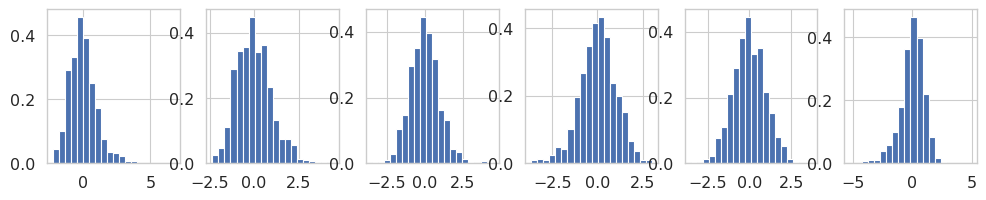

In [194]:
fig, ax = plt.subplots(1, d, figsize=(2*d, 2))
xx = np.linspace(-3, 3, 100)
for j in range(d):
    ax[j].hist(train_samples[:, j], bins=20, density=True)

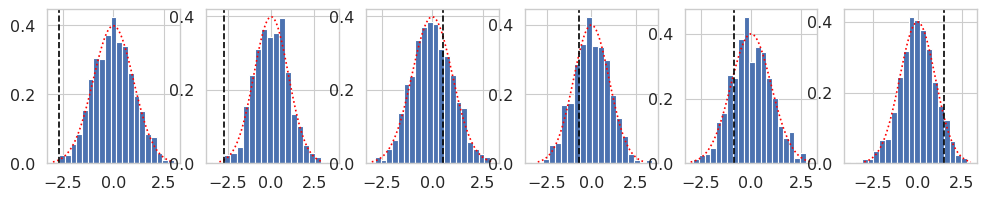

In [195]:
fig, ax = plt.subplots(1, d, figsize=(2*d, 2))
xx = np.linspace(-3, 3, 100)
for j in range(d):
    ax[j].hist(Z[:, j], bins=20, density=True)
    ax[j].plot(xx, norm.pdf(xx), color='red', ls=':')
    ax[j].axvline(z_value[j], color='black', ls='--')

In [196]:
import jax.numpy as jnp
import jax
from jax.scipy.special import logsumexp

In [197]:
def neg_loglik(suff_stat, beta_null):
    suff_stat_center_ = cov_chol.T @ (suff_stat - mean_shift)
    return model.apply(params, suff_stat_center_, beta_null, method=model.forward_kl)

pvalues_adjusted = np.zeros(d)
cis_adjusted = np.zeros((d, 2))

for j in range(d):
    c = np.eye(d)[j]
    beta_perp = suff_stat - c * suff_stat[j]
    gridsize = 200
    grid = jnp.linspace(-5, 5, gridsize) * sd_suff_stat[j] + suff_stat[j]

    @jax.jit
    def logp_j(beta_hat_j, beta_null_j):
        beta_ = jnp.zeros(d)
        beta_ = beta_.at[j].set(beta_null_j)
        return -neg_loglik(beta_perp + c * beta_hat_j, beta_)

    @jax.jit
    def get_pvalue(beta_null_j):
        logp = jax.vmap(logp_j, in_axes=(0, None))(grid, beta_null_j)
        isnan = jnp.all(jnp.isnan(logp))
        logp = jnp.nan_to_num(logp, nan=-np.inf)
        logp -= logp.max()
        log_normalization_const = logsumexp(logp)

        idx_left = (grid <= suff_stat[j]) 
        log_numerator_left = logsumexp(jnp.where(idx_left, logp, -jnp.inf))
        pval = jnp.exp(log_numerator_left - log_normalization_const)
        pval = jax.lax.select(pval < 0.5, 2 * pval, 2 * (1 - pval))
        return jax.lax.select(isnan, 0., pval)

    pvalues_adjusted[j] = get_pvalue(0.)
    cis_adjusted[j] = ci_bisection(get_pvalue, sd_beta[j], beta_hat[j] + 5 * sd_beta[j], beta_hat[j] - 5 * sd_beta[j], sig_level=sig_level, tol=1e-4)

In [200]:
cis_naive_ = []
cis_adjusted_ = []
for j in range(d):
    cis_naive_.append('({:.3f}, {:.3f})'.format(cis_naive[j][0], cis_naive[j][1]))
    cis_adjusted_.append('({:.3f}, {:.3f})'.format(cis_adjusted[j][0], cis_adjusted[j][1]))

In [201]:
results = pd.DataFrame({('naive', 'pval'): np.round(pvalues_naive, 3), 
                         ('naive', 'ci'): cis_naive_,
                         ('Proposed', 'pval'): np.round(pvalues_adjusted, 3), 
                         ('Proposed', 'ci'): cis_adjusted_})

In [202]:
results

naive                   Proposed                  
    pval                ci     pval                ci
0  0.000  (-1.913, -0.581)    0.005  (-1.844, -0.353)
1  0.000  (-4.117, -2.375)    0.001  (-4.660, -2.701)
2  0.022  (-1.609, -0.125)    0.757   (-2.967, 1.187)
3  0.516   (-0.810, 0.407)    0.814   (-2.063, 1.090)
4  0.588   (-0.379, 0.668)    0.258   (-0.343, 1.208)
5  0.136   (-0.162, 1.186)    0.887   (-4.637, 1.301)

In [ ]:
# results.to_latex('experiments/single_cell/results.tex', index=True, float_format='%.3f')